In [1]:
!pip install --upgrade --user git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-4vc4nx34
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-4vc4nx34
  Using cached https://files.pythonhosted.org/packages/1f/df/7988fbbdc8c9b8efb575029498ad84b77e023a3e4623e85068823a102b1d/numpy-1.18.4-cp37-cp37m-manylinux1_x86_64.whl
  Created wheel for dm-haiku: filename=dm_haiku-0.0.1b0-cp37-none-any.whl size=216854 sha256=c10165a110d178c91251d0d55bb70d66d90cfcd4f666af93ccbc5230e3c64654
  Stored in directory: /tmp/pip-ephem-wheel-cache-ubg6r2ca/wheels/97/0f/e9/17f34e377f8d4060fa88a7e82bee5d8afbf7972384768a5499
Successfully built dm-haiku
ERROR: tensorflow-federated 0.13.1 has requirement numpy~=1.17.5, but you'll have numpy 1.18.4 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5
  Found existing installation: dm-haiku 0.0.1b0
    Uninstalling dm-haiku-0.0.1b0:
      Successfully uninsta

In [4]:
!pip install --upgrade --user numpy

Requirement already up-to-date: numpy in /home/grimberg/.local/lib/python3.7/site-packages (1.18.4)


In [1]:
!pip install --user setGPU

In [30]:
import setGPU

NVMLError_GpuIsLost: GPU is lost

In [1]:
!export CUDA_VISIBLE_DEVICES=7

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import Any, Generator, Tuple, Mapping, Sequence, Optional, Callable, Union, NamedTuple
from collections import namedtuple
import functools, inspect, time, random

import pandas as pd
import numpy as np
from absl import app
import haiku as hk
import jax
from jax.experimental import optix
from jax.tree_util import tree_multimap, tree_map, tree_reduce, tree_leaves
import jax.numpy as jnp
from jax.lax import fori_loop
import tensorflow_datasets as tfds
import tensorflow as tf

import module.utils as utils
from module.custom_types import *

In [4]:
# extracts messages from a list of client outputs.
@jax.partial(jax.jit, static_argnums=[1])  # fix extractor.
def extract_from_cout(
    couts: Sequence[ClientOutput],
    extractor: Callable[[ClientOutput], Any]
    ) -> Sequence[Any]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  # TODO: use pytrees.transpose?
  # msgs = fori_loop(0, len(couts),
  #                    lambda i, msgs: msgs.append(extractor(couts[i])), [])
  msgs = [extractor(cout) for cout in couts]
  return msgs

def init_client_states(client_data: Sequence[tf.data.Dataset]) -> Sequence[ClientState]:
  return [ClientState() for i in range(len(client_data))]

def make_jax_batch(batch: Mapping[str, tf.Tensor]) -> Batch:
    """Transform a Mapping[str, tf.Tensor] (tensorflow batch)
    into a Mapping[str, jnp.array] (jax-compatible batch)."""
    jax_batch = {}
    for key in batch:
        jax_batch[key] = jnp.array(batch[key].numpy())
    return jax_batch

In [5]:
def make_dss(clients: Sequence[Tuple[np.ndarray, np.ndarray]],
             hyperparams: ServerHyperParams,
             requesting_client: int = 0,
             test_ratio: float = 0.5
) -> Tuple[DatasetSequence, tf.data.Dataset]:
    """Make batched `tf.data.Dataset`s based on the (X,y) tuples representing
    each client's data. 
    
    requesting_client: Index of the age group for which a test set is created.
    The training set for the requesting client is placed at index 0 in the returned
    DatasetSequence."""
    if requesting_client < 0 or requesting_client >= len(clients):
        raise ValueError("Unexpected 'requesting_client' argument: "
                         "Expecting a non-negative int lower than "
                         "{}.".format(len(clients)))
    
    dss, ds_test = [None], None
    for i, (X,y) in enumerate(clients):
        if i == requesting_client:
            test_size = hyperparams.batch_size * (1 + int(y.shape[0] // hyperparams.batch_size * test_ratio))
            ds_test = utils.make_ds(X[:test_size], y[:test_size], hyperparams.batch_size)
            dss[0] = utils.make_ds(X[test_size:], y[test_size:], hyperparams.batch_size)
        else:
            dss.append( utils.make_ds(X, y, hyperparams.batch_size) )
    
    assert (ds_test is not None)
    
    return dss, ds_test

In [6]:
# hyperparams = ServerHyperParams(
#     num_rounds = 30,
#     max_batches_per_round = 3,
#     max_epochs_per_round = 1,
#     batch_size = 10,
#     seed = 420
# )
# dss, ds_test = make_dss(split_by_age(*load_2017annie_predict_EVD()), hyperparams)    

In [7]:
# for batch in ds_test:
#     print(batch)

In [8]:
# Neural network model.
def net_fn(batch: Batch) -> jnp.ndarray:
  """Logistic regression for 2-class classification."""
  x = batch["features"]
  logistic_reg = hk.Sequential([
      hk.Flatten(),
      hk.Linear(2, with_bias=True), jax.nn.log_softmax
  ])
  return logistic_reg(x)
net: hk.Transformed = hk.transform(net_fn)

# Initialize neural network parameters 
def init(rng: jax.random.PRNGKey, batch: Batch) -> hk.Params:
  return net.init(rng, batch)

# get predictions from model.
def forward(params: hk.Params, batch: Batch):
  return jax.jit(net.apply)(params, batch)


# Training loss (cross-entropy).
@jax.jit
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  preds = forward(params, batch)
  labels = hk.one_hot(batch["label"], 2)
  # TODO: Put weight decay into optimizer
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
  softmax_xent = -jnp.mean(labels * preds)
  return softmax_xent + 1e-4 * l2_loss

# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  preds = forward(params, batch)
  pred_class = jnp.argmax(preds, axis=-1)
  return jnp.mean(pred_class == batch["label"])

In [9]:
# one local update step.
@jax.partial(jax.jit, static_argnums=[2,4])  # fix loss function and optimizer.
def run_one_step(
    params: hk.Params,
    batch: Batch,
    client_opt: optix.InitUpdate,
    opt_state: OptState,
    loss: LossFunction
    ) -> Tuple[hk.Params, OptState]:
  """Learning rule (stochastic gradient descent)."""
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  grads = jax.grad(loss)(params, batch)
  updates, opt_state = client_opt.update(grads, opt_state)
  new_params = optix.apply_updates(params, updates)
  return new_params, opt_state  

# perform client updates.
def client_updater(
    msg: ClientMessage,
    ds: Sequence[Batch],
    client_opt: optix.InitUpdate,
    loss: LossFunction
    ) -> ClientOutput:
  opt_state = client_opt.init(*msg.opt_init_input)
  # iterate through data making updates.
  new_params = msg.params
  train_loss, train_acc = [], []
  for minibatch in ds:
    new_params, opt_state = run_one_step(new_params,
                                         minibatch,
                                         client_opt, 
                                         opt_state, 
                                         loss)
    train_loss.append(loss(msg.params, minibatch))
    train_acc.append(accuracy(msg.params, minibatch))
  # compute and return the change in parameters.
  params_update = tree_multimap(lambda x, y: x - y, new_params, msg.params)
  
  # TODO: replace with an function which constructs message  
  msg_to_server = ServerMessage(
      aggregator_input=params_update,
      stateupdater_input=None
  )

  diagnostic_msg = DiagnosticsMessage(
      train_loss=np.mean(train_loss),
      train_acc=np.mean(train_acc),
      test_loss=0,
      test_acc=1,
      weight=len(train_loss)
  )
  return msg_to_server, diagnostic_msg

In [10]:
# Absolutely not suitable for jit-compilation.
def make_client_data(
    ds: tf.data.Dataset,
    client_state: ClientState,
    hyperparams: ServerHyperParams
) -> Tuple[Sequence[Batch], ClientState]:
  batches_before, batches_after = [], []
  
  # Initially skip all the way to client_state.next_idx:
  for i, batch in enumerate(ds):
    if i < client_state.next_idx:
      batches_before.append(
        make_jax_batch(batch)
      )
    # Return once num_batches batches have been selected:
    elif len(batches_after) >= hyperparams.max_batches_per_round:
      client_state = client_state._replace(next_idx = i)
      return batches_after, client_state
    # Transform the tf batch to a Batch (Mapping[str, jnp.array])
    else:
      batches_after.append(
        make_jax_batch(batch)
      )
  
  # Increment the client's epoch count once, because we've reached
  # the end of the dataset:
  client_state = client_state._replace(
                            next_idx = 0,
                            epoch_count = client_state.epoch_count + 1
                            )
  
  # Traverse the dataset up to max_epochs-1 more times, until num_batches
  # batches are in batches_after
  for epoch in range(hyperparams.max_epochs_per_round - 1):
    
    for i, batch in enumerate(ds):
      # Return once num_batches batches have been selected:
      if len(batches_after) >= hyperparams.max_batches_per_round:
        client_state = client_state._replace(next_idx = i)
        return batches_after, client_state
      # Transform the tf batch to a Batch (Mapping[str, jnp.array])
      batches_after.append(
        make_jax_batch(batch)
      )
    
    # Increment the client's epoch_count
    client_state = client_state._replace(
                            next_idx = 0,
                            epoch_count = client_state.epoch_count + 1
                            )
  
  # If num_batches has not yet been reached,
  # add (some or all of) the batches_before at the end:
  num_to_add = hyperparams.max_batches_per_round - len(batches_after)
  batches_to_add = batches_before[:num_to_add]
  client_state = client_state._replace(next_idx = len(batches_to_add))
  batches_after += batches_to_add
  return batches_after, client_state

def make_all_client_data(
    client_data: Sequence[tf.data.Dataset],
    client_states: Sequence[ClientState],
    hyperparams: ServerHyperParams
) -> Tuple[Sequence[Sequence[Batch]], Sequence[ClientState]]:
  if not (len(client_states) == len(client_data)):
    raise ValueError(
        "Number of datasets ({}) does not fit number of client "
        "states ({})!".format(len(client_data), len(client_states))
        )
  dss_jax, client_states_after = [], []
  for ds, client_state_before in zip(client_data, client_states):
    batches_jax, client_state_after = make_client_data(ds, client_state_before, hyperparams)
    dss_jax.append(batches_jax)
    client_states_after.append(client_state_after)
  return dss_jax, client_states_after

In [11]:
# aggregate client updates.
# TODO: make the aggregator stateful.
@jax.jit
def average_params(params_list: Sequence[hk.Params],
                   client_states: Sequence[ClientState],
                   hyperparams: AverageAggregatorHyperParams
                  ) -> hk.Params: 
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  num_params = len(params_list)
  params_sum = functools.reduce(
      lambda t1, t2: tree_multimap(sum, t1, t2), params_list)
  params_avg = tree_map(lambda x: x/num_params, params_sum)
  return params_avg, client_states

@jax.jit
def normalize_array_l2(x: jnp.array) -> jnp.array:
    print("compiling: {}".format(inspect.currentframe().f_code.co_name))
    return x / jnp.sqrt(jnp.dot(x, x))

@jax.jit
def normalize_array_l1(x: jnp.array) -> jnp.array:
    print("compiling: {}".format(inspect.currentframe().f_code.co_name))
    return x / jnp.sum(jnp.abs(x))

@jax.jit
def tree_norm(tree: hk.Params) -> jnp.array:
    print("compiling: {}".format(inspect.currentframe().f_code.co_name))
    return jnp.sqrt(
               jnp.sum(
                   tree_leaves(
                       tree_map(
                           lambda x: jnp.sum(x*x),
                           tree
                       )
                   )
               )
           )

@jax.jit
def calc_rel_distances_of_others(reference_update: hk.Params,
                                 other_updates: Sequence[hk.Params]
                                ) -> Sequence[Any]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  # Compare the distances to the norm of the reference update.
  reference_norm = tree_norm(reference_update)
  return [ tree_norm(tree_multimap(lambda x, y: x-y, update, reference_update))
           / reference_norm 
           for update in other_updates ]

@jax.partial
def sum_args(*args):
  print("compiling: {} with {} arguments".format(inspect.currentframe().f_code.co_name, len(args)))
  return sum(args)

@jax.jit
def similarity_aggregator(updates_list: Sequence[hk.Params],
                          client_states: Sequence[ClientState],
                          hyperparams: SimilarityAggregatorHyperParams
                         ) -> Tuple[hk.Params, Sequence[ClientState]]:
    print("compiling: {}".format(inspect.currentframe().f_code.co_name))
    assert len(updates_list) == len(client_states)
    reference_update = updates_list[0]
    other_updates = updates_list[1:]
    rel_distances_of_others = calc_rel_distances_of_others(reference_update,
                                                           other_updates)
    print("rel_distances_of_others:", rel_distances_of_others)
    
    # Each dataset starts with a similarity of 1, which can only decrease over time.
    # At every round, each dataset's similarity could decrease by something like:
    # some_factor * (1+client_state.epoch_count) * rel_distance
    for client_id, rel_distance in enumerate(rel_distances_of_others, start=1):
        c = client_states[client_id]
        print(c.similarity)
        decrement = hyperparams.distance_penalty_factor * (1+0.2*c.epoch_count) * rel_distance
        similarity = jnp.max([0, c.similarity - decrement]).astype(float)
        client_states[client_id] = c._replace(similarity=similarity)
    
    print([c.similarity for c in client_states])
    weights = normalize_array_l1(jnp.array([c.similarity for c in client_states]))
    weighted_updates = [tree_map(lambda x: w*x, update) for w, update in zip(weights, updates_list)]
    aggregated_update = tree_multimap(sum_args, *weighted_updates)
    return aggregated_update, client_states

def init_average_aggregator():
    return Aggregator(aggregator_function    = average_params,
                      aggregator_hyperparams = AverageAggregatorHyperParams()
                     )

def init_similarity_aggregator(distance_penalty_factor: float = 0.05) -> Aggregator:
    similarity_hyperparams = SimilarityAggregatorHyperParams(
            distance_penalty_factor=distance_penalty_factor
    )
    return Aggregator(aggregator_function    = similarity_aggregator,
                      aggregator_hyperparams = similarity_hyperparams
                     )

In [12]:
# # initialize random generator, params, opt_state.
# num_splits = 4
# rng = jax.random.PRNGKey(hyperparams.seed)
# rngs = jax.random.split(rng, num_splits+1)

In [13]:
# updates_list = [init(rngs[i], dss[0].as_numpy_iterator().next()) for i in range(num_splits+1)]
# client_states = [ClientState() for i in range(num_splits+1)]
# client_states = similarity_aggregator(updates_list, client_states, SimilarityAggregatorHyperParams(0.05))[1]

In [14]:
# for i in range(3):
#     reference_update = init(rngs[-1], dss[0].as_numpy_iterator().next())
#     other_updates = [init(rngs[i], dss[0].as_numpy_iterator().next()) for i in range(num_splits)]
#     print(calc_rel_distances_of_others(reference_update, other_updates))

 DeviceArray(1.3672365, dtype=float32), DeviceArray(1.3019154, dtype=float32), DeviceArray(1.5341283, dtype=float32), DeviceArray(1.6079143, dtype=float32)]

In [15]:
# for i in range(3):
#     reference_update = init(rngs[0], dss[0].as_numpy_iterator().next())
#     other_updates = [init(rngs[i+1], dss[0].as_numpy_iterator().next()) for i in range(num_splits)]
#     print(calc_rel_distances_of_others(reference_update, other_updates))

running round 0
computing updates from active clients.
compiling: run_one_step
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout
compiling: similarity_aggregator
compilinserver_paramsalc_rel_distances_of_others
frozendict({
  'linear': frozendict({
              'b': Traced<ShapedArray(float32[2]):JaxprTrace(level=-1/3)>,
              'w': Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/3)>,
            }),
})
Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/3)>
<class 'jax.interpreters.partial_eval.JaxprTracer'> : Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/3)>
rel_distances_of_others: [Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>]
Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/2)>
Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/2)>
[Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>]

In [16]:
# aggregate diagnositcs.
def agg_diagnostics(
    client_outputs: Sequence[ClientOutput]) -> DiagnosticsMessage:
  d_msgs = extract_from_cout(client_outputs, lambda cout: cout[1])
  # TODO: aggregate and report statistics
  total_weights = np.sum([msg.weight for msg in d_msgs])

  train_loss = np.sum([msg.train_loss for msg in d_msgs]) / total_weights
  train_acc =  np.sum([msg.train_acc for msg in d_msgs])  / total_weights
  return DiagnosticsMessage(train_loss=train_loss,
                            train_acc = train_acc,
                            test_loss=0,
                            test_acc=1,
                            weight=total_weights
                           )


# update server params.
@jax.partial(jax.jit, static_argnums=[3,5])  # fix optimizer and aggregator.
def server_updater(
    server_params: hk.Params,
    client_outputs: Sequence[ClientOutput],
    client_states: Sequence[ClientState],
    server_opt: optix.InitUpdate,
    opt_state: OptState,
    aggregator: Aggregator
) -> Tuple[hk.Params, Sequence[ClientState], OptState]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  agg_inputs = extract_from_cout(client_outputs,
                                 lambda cout: cout[0].aggregator_input)
  agg_update, client_states_out = aggregator.aggregator_function(
                                                agg_inputs,
                                                client_states,
                                                aggregator.aggregator_hyperparams
                                                )
  eff_grads = tree_map(lambda x: -1.0*x, agg_update)  # effective gradient.
  updates, opt_state = server_opt.update(eff_grads, opt_state)
  # TODO: allow opt_state to also be explicitly updated by state_updater
  server_params = optix.apply_updates(server_params, updates)
  return server_params, client_states_out, opt_state

# one round of federated learning.
def run_one_round(
    server_params: hk.Params,
    hyperparams: ServerHyperParams,
    client_data: Sequence[tf.data.Dataset],
    client_states: Sequence[ClientState],
    client_opt: optix.InitUpdate,
    server_opt: optix.InitUpdate,
    opt_state: OptState,
    aggregator: Aggregator,
    loss: LossFunction,
    rng: jax.random.PRNGKey
) -> Tuple[hk.Params, Sequence[ClientState], OptState]:
  
  print("computing updates from active clients.")
  # TODO: replace with an function which constructs message
  msg_to_clients = ClientMessage(
      params=server_params, 
      opt_init_input=[server_params])
  
  dss, client_states_upd = make_all_client_data(client_data, client_states, hyperparams)
  
  client_outputs = list(map(lambda ds: client_updater(
                          msg_to_clients,
                          ds,
                          client_opt,
                          loss), dss))
  
  print("aggregating client updates.")
  server_params, client_states_out, opt_state = server_updater(
      server_params,
      client_outputs,
      client_states_upd,
      server_opt,      
      opt_state,      
      aggregator)
  
  # TODO: aggregate and incporate new diagnostics. needs state!
  diagnostics = agg_diagnostics(client_outputs)
  
  return server_params, client_states_out, opt_state, diagnostics

In [17]:
# # Testing one round of federated averaging.
# batch_size=10
# dss, ds_test = split_by_age(*load_2017annie_predict_EVD(), batch_size)
# client_states = init_client_states(dss)

In [18]:
# params = init(jax.random.PRNGKey(42), dss[0].as_numpy_iterator().next())

In [19]:
# client_opt = optix.sgd(0.1)
# server_opt = optix.sgd(1.0)
# opt_state = server_opt.init(params)
# rng = jax.random.PRNGKey(0)
# hyperparams = ServerHyperParams(
#     num_rounds = 12,
#     max_batches_per_round = 5000,
#     max_epochs_per_round = 1,
#     batch_size = 10,
#     seed = 7
# )

# run_one_round(
#     params,
#     hyperparams,
#     dss,
#     client_states,
#     client_opt,
#     server_opt,
#     opt_state,
#     average_params,
#     loss,
#     rng
# );

In [20]:
def eval_test_accuracy(params: hk.Params, ds: Sequence[Batch]) -> np.float64:
    accs = []
    for batch in ds:
        accs.append(accuracy(params, batch))
    return np.mean(accs)

def eval_test_loss(params: hk.Params, ds: Sequence[Batch]) -> np.float64:
    losses = []
    for batch in ds:
        losses.append(loss(params, batch))
    return np.mean(losses)

def make_jax_dataset(ds: tf.data.Dataset) -> Sequence[Batch]:
    jax_ds = []
    for batch in ds:
        jax_ds.append(make_jax_batch(batch))
    return jax_ds

In [21]:
def update_diagnostics(diag_state: DiagnosticsState,
                       diagnostics: DiagnosticsMessage,
                       client_states: Sequence[ClientState],
                       server_params: hk.Params,
                       ds_test: Sequence[Batch]
                      ) -> DiagnosticsState:
    diag_state_upd = DiagnosticsState(
                        train_loss_global     = diag_state.train_loss_global     + [diagnostics.train_loss],
                        train_accuracy_global = diag_state.train_accuracy_global + [diagnostics.train_acc],
                        test_loss             = diag_state.test_loss     + [eval_test_loss(    server_params, ds_test)],
                        test_accuracy         = diag_state.test_accuracy + [eval_test_accuracy(server_params, ds_test)],
                        similarities          = diag_state.similarities + [[float(c.similarity) for c in client_states]],
                        epoch_counts          = diag_state.epoch_counts + [[int(c.epoch_count) for c in client_states]]
                       )
    return diag_state_upd

In [22]:
def federated_learning(
    client_data: Sequence[tf.data.Dataset],
     aggregator: Aggregator,
        ds_test: Sequence[Batch],
    hyperparams: ServerHyperParams,
     client_opt: optix.InitUpdate,
     server_opt: optix.InitUpdate,
           loss: LossFunction,
           init
    ) -> hk.Params:
  # initialize random generator, params, opt_state.
  rng = jax.random.PRNGKey(hyperparams.seed)
  # TODO: use synthethic data for init
  server_params = init(rng, client_data[0].as_numpy_iterator().next())
  client_states = init_client_states(client_data)
  opt_state = server_opt.init(server_params)
  rngs = jax.random.split(rng, hyperparams.num_rounds)
  
  diag_state = DiagnosticsState()
  for round_num, rng in enumerate(rngs):
    print("\nrunning round {}".format(round_num))
    server_params, \
    client_states, \
    opt_state,     \
    diagnostics,     = run_one_round(server_params, hyperparams, 
                                    client_data, client_states, client_opt, 
                                    server_opt, opt_state, 
                                    aggregator, loss, rng)
    diag_state = update_diagnostics(diag_state, diagnostics, client_states, server_params, ds_test)
  
  # At each round, the training loss and accuracy are computed based on the
  # server_params *before* the round, while the test diagnostics are computed
  # from the server_params *after* the round. This is corrected here:
  diag_state = diag_state._replace(train_loss_global     = diag_state.train_loss_global[1:],
                                   train_accuracy_global = diag_state.train_accuracy_global[1:]
                                  )
  return server_params, diag_state

# Run a federated learning simulation

In [23]:
# testing federated learning code.

hyperparams = ServerHyperParams(
    num_rounds = 30,
    max_batches_per_round = 3,
    max_epochs_per_round = 1,
    batch_size = 10,
    seed = 420
)

sim_aggregator = init_similarity_aggregator()
avg_aggregator = init_average_aggregator()

constant_inputs = (
        hyperparams,
        optix.sgd(0.1),
        optix.sgd(1.0),
        loss,
        init
)

client_sets = utils.load(utils.SetLoaders.TITANIC_SURVIVED, utils.Splitters.AGE_STRICT, hyperparams.seed)
diagnostics = {}
for requesting_client in range(len(client_sets)):
    dss, ds_test = make_dss(client_sets, hyperparams, requesting_client)
    jax_ds_test  = make_jax_dataset(ds_test)
    
    training_types = {
        'global' : (dss,      avg_aggregator),
        'similar': (dss,      sim_aggregator),
        'local'  : (dss[0:1], avg_aggregator),
    }

    for key, varied_inputs in training_types.items():
        opt_params_global, \
        diag_state          = federated_learning(*varied_inputs,
                                                 jax_ds_test,
                                                 *constant_inputs
                                                );
        if not key in diagnostics:
            diagnostics[key] = []
        diagnostics[key].append( diag_state )

/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4979: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



running round 0
computing updates from active clients.
compiling: run_one_step
compiling: loss
compiling: loss
compiling: accuracy
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout
compiling: average_params
compiling: extract_from_cout

running round 1
computing updates from active clients.
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout
compiling: average_params
compiling: extract_from_cout

running round 2
computing updates from active clients.
aggregating client updates.
compiling: extract_from_cout

running round 3
computing updates from active clients.
aggregating client updates.
compiling: extract_from_cout

running round 4
computing updates from active clients.
aggregating client updates.
compiling: extract_from_cout

running round 5
computing updates from active clients.
aggregating client updates.
compiling: extract_from_cout

running round 6
computing updates from active clients.
aggregating client updates.


/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4979: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>]
compiling: normalize_array_l1
compiling: sum_args with 3 arguments
compiling: sum_args with 3 arguments
compiling: extract_from_cout

running round 1
computing updates from active clients.
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout
compiling: similarity_aggregator
rel_distances_of_others: [Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>]
Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>
Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>
[Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[]):JaxprTrace(level=-1/2)>]
compiling: sum_args with 3 arguments
compiling: sum_args with 3 arguments
compiling: extract_from_cout


# Display results

In [24]:
diagnostics['similar'][0]

DiagnosticsState(train_loss_global=[2.024414486355252, 2.4682129753960504, 2.3526611328125, 0.26731718911064994, 0.3179040220048692, 3.8164990743001304, 2.4626776377360025, 0.10067078802320692, 0.1938024361928304, 0.6970174047682021, 3.574793497721354, 3.9058736165364585, 1.0788667466905382, 6.247904459635417, 0.8642155329386393, 8.208033243815104, 3.9411354064941406, 1.1589529249403212, 9.763795640733507, 0.5330611864725748, 6.9448598225911455, 5.326504177517361, 0.9687668482462565, 4.7405649820963545, 0.6361107296413846, 4.153374989827474, 2.750367906358507, 1.4308170742458768, 6.936475541856554], train_accuracy_global=[0.12222222487131755, 0.19999999470180935, 0.22592592239379883, 0.11851852469974095, 0.1740740802552965, 0.19259259435865614, 0.1777777804268731, 0.23703702290852866, 0.20370370811886257, 0.1444444391462538, 0.21851852205064562, 0.19999999470180935, 0.1018518606821696, 0.2370370493994819, 0.15925925307803684, 0.20370369487338597, 0.20000000794728598, 0.0962962971793280

In [25]:
import matplotlib.pyplot as plt
markers = {k:v for k,v in zip(diagnostics.keys(), 'ox+svp'*8)}
colors = {k:v for k,v in zip(diagnostics.keys(), 'grbkcm'*8)}
for key, val in diagnostics.items():
    test_acc = [val[i].test_accuracy[-1] for i in range(len(val))]
    x = np.arange(len(val))
    plt.scatter(x, test_acc, label=key, marker=markers[key], s=60)
plt.legend()
plt.xlabel('requesting client')
plt.ylabel('accuracy on the test set')
plt.title("Final test accuracy")
plt.show()

<Figure size 640x480 with 1 Axes>

In [26]:
def average_diag_states(dstates: Sequence[DiagnosticsState]) -> DiagnosticsState:
    args = [np.mean([ d[i] for d in dstates], axis=0)
            for i in range(len(dstates[0]))]
    return DiagnosticsState(*args)
    
avg_diagnostics = {}
for key, dlist in diagnostics.items():
    avg_diagnostics[key] = average_diag_states(dlist)
avg_diagnostics

{'global': DiagnosticsState(train_loss_global=array([10.81946875, 19.20368717, 23.97719913,  6.39683116,  8.51556912,
         8.6586801 ,  3.91871198,  5.24568812,  3.37632681, 11.21448418,
        16.68185962, 10.9263536 , 23.89623402, 25.76152378, 24.30734486,
        25.29338017,  9.7295812 ,  7.22225164,  2.16621194,  8.54525559,
        19.65325363, 30.70107806, 12.26311366,  7.94637673, 12.19196094,
        19.28443139, 14.2897785 , 14.54264648, 16.37406957]), train_accuracy_global=array([0.15802469, 0.1728395 , 0.17407408, 0.18641975, 0.18888889,
        0.17839506, 0.14197531, 0.23209876, 0.12592593, 0.1728395 ,
        0.14691358, 0.16049382, 0.15740742, 0.15679012, 0.16790123,
        0.13209877, 0.16049382, 0.18518518, 0.18580248, 0.15679012,
        0.18765432, 0.14814815, 0.18395062, 0.11975308, 0.21111111,
        0.12777778, 0.16234567, 0.19382717, 0.15555556]), test_loss=array([ 29.35311 ,  44.53648 ,  55.246033,  50.742664,  35.65787 ,
         34.217163,  13.43448 , 

In [27]:
# Plot the evolution of test accuracy and client similarities during training
def plot_test_accuracy_and_similarities(diags: Mapping[str, DiagnosticsState], title=''):
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax1.set_xlabel("Communication round")
    ax2 = ax1.twinx()

    handles_methods, labels_methods, handles_sim = [], [], []
    for key, dstate in diags.items():
        m = markers[key]
        c = colors[key]
        h, = ax1.plot(dstate.test_accuracy, '-'+m+c)
        handles_methods.append(h)
        labels_methods.append(key)
        if key not in ('global', 'local'):
            handles_sim = ax1.plot(dstate.similarities, ':')
            num_clients = np.array(dstate.similarities).shape[1]
            ax2.plot(dstate.epoch_counts, ':')
    ax1.set_ylabel("Similarity / Test Accuracy")
    ax1.set_ylim((-0.02,1.02))
    ax2.set_ylabel("Epoch count")
    handles = handles_methods + handles_sim
    labels = labels_methods + ['client {}'.format(i) for i in range(num_clients)]
    ax1.legend(handles, labels)
    plt.title(title)
    plt.show()

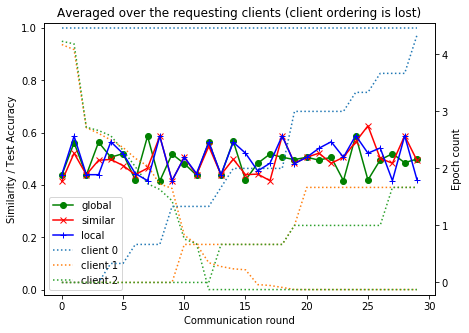

In [28]:
# averaged over the various requesting clients
plot_test_accuracy_and_similarities(avg_diagnostics, "Averaged over the requesting clients (client ordering is lost)")

In [29]:
def get_diagnostics_for_requesting_client(dstates: Mapping[str, Sequence[DiagnosticsState]],
                                          requesting_client: int
                                         ) -> Mapping[str, DiagnosticsState]:
    """
    INPUTS:
        dstates: dict
            key: data set selection strategy (e.g., 'global' or 'similar')
            value: list of DiagnosticsState. Each DiagnosticsState
                   corresponds to one requesting client.
        requesting_client: int
    
    OUTPUTS:
        res: dict
            key: data set selection strategy (same keys as input `dstates`)
            value: DiagnosticsState corresponding to client `requesting_client`.
            
    The DiagnosticsState.similarities and DiagnosticsState.epoch_counts are reordered,
    to maintain the identity of each dataset. For example, the dataset
    (, similarity, and epoch_count,) of client 1 are at index 1 irrespectively of
    who the requesting client is. This is not the case in the raw training results.
    """
    res = {}
    for key, dlist in diagnostics.items():
        dstate = dlist[requesting_client]
        similarities = np.array(dstate.similarities)
        num_clients = similarities.shape[1]
        
        indexes_reordered = list(range(1, requesting_client+1)) + [0] + list(range(requesting_client+1, num_clients))
        if requesting_client >= num_clients:
            indexes_reordered = list(range(num_clients))
        
        similarities_reordered = np.array(dstate.similarities).T[indexes_reordered].T
        epoch_counts_reordered = np.array(dstate.epoch_counts).T[indexes_reordered].T
#         print(num_clients, indexes_reordered)
#         print(similarities_reordered)
        res[key] = dstate._replace(similarities=similarities_reordered,
                                   epoch_counts=epoch_counts_reordered
                                  )
    return res

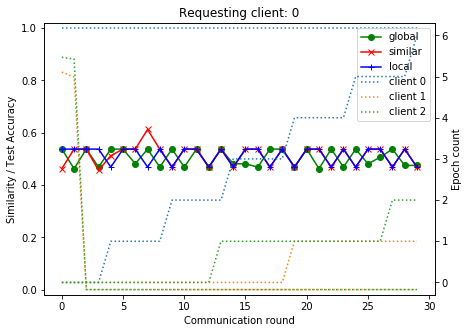

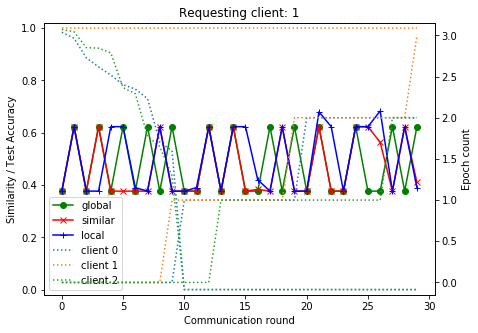

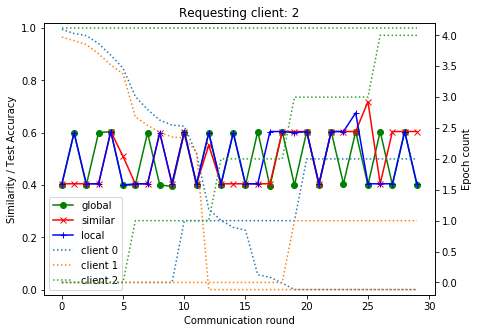

In [30]:
# Individually per requesting client
for requesting_client in range(len(diagnostics['similar'])):
    plot_test_accuracy_and_similarities(
        get_diagnostics_for_requesting_client(diagnostics, requesting_client),
        "Requesting client: {}".format(requesting_client)
    )

# Questions

1. Does the net.init also initialize the output layer based on batch size?